# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis, flop_count_table
import numpy as np
import matplotlib.pyplot as plt
import os

####################################################
from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 256
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0.9
"""optimizer parameters"""
OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"

"""Learning rate scheduler parameters"""
# LOAD_BEFORE_TRAINING = False
LOAD_BEFORE_TRAINING = True
NUM_EPOCHS = 100000

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 3000
file_path = ""
if DATASET == "ImageNet2012":
    file_path = f"{DATASET}/MyResNet34_{BATCH}_{OPTIMIZER}"
else:
    file_path = f"{DATASET}/MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"
    
if SPLIT_RATIO != 0:
    file_path += f"_{int(SPLIT_RATIO*100)}"

In [3]:
file_path

'CIFAR10/MyResNet32_256_SGD_90'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  45000
- Length of Valid Set :  5000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("train.transforms =", train_data.transform, train_dataloader.batch_size)

if SPLIT_RATIO != 0:
    valid_dataloader = DataLoader(
        valid_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("valid.transforms =", valid_data.transform, valid_dataloader.batch_size)
elif SPLIT_RATIO == 0:
    valid_dataloader = None

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("test.transforms =", test_data.transform, test_dataloader.batch_size)

train.transforms = Compose(
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
) 256
valid.transforms = ToTensor() 256
test.transforms = ToTensor() 256


## Confirm that the dataset is loaded properly

In [6]:
if DATASET != "ImageNet2012":
    for X, y in test_dataloader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print("mean of X", X.mean(dim=(0, 2, 3)))
        print(f"Shape of y: {y.shape} {y.dtype}")
        break

Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
mean of X tensor([0.5086, 0.5046, 0.4621])
Shape of y: torch.Size([256]) torch.int64


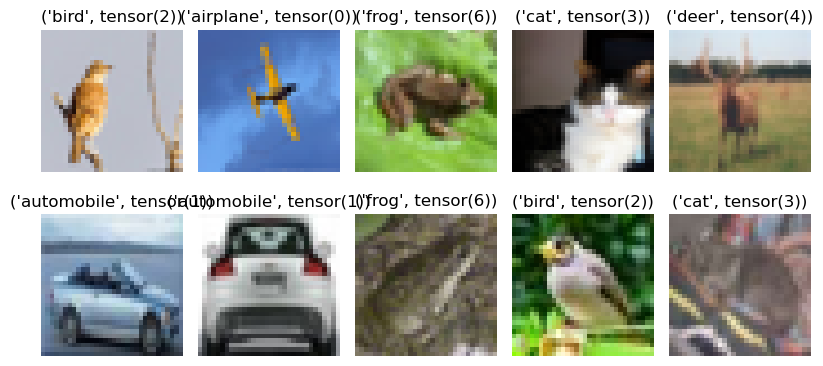

In [7]:
if DATASET != "ImageNet2012":
    class_names = test_dataloader.dataset.classes
    count = 0
    fig, axs = plt.subplots(2, 5, figsize=(8, 4))

    for images, labels in test_dataloader:
        images = images.numpy()

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            ax = axs[count // 5, count % 5]
            ax.imshow(image)
            ax.set_title(f"{class_names[label], label}")
            ax.axis('off')
            count += 1
            
            if count == 10:
                break
        if count == 10:
            break
    plt.tight_layout()
    plt.show()

# Define ResNet

## Model Confirm

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=COUNT_OF_CLASSES,
        num_layer_factor=NUM_LAYERS_LEVEL,
        Downsample_option="A",
    ).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(
        num_classes=COUNT_OF_CLASSES, 
        Downsample_option="A"
    ).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")


ResNet-32 for CIFAR10 is loaded.


In [10]:
model.named_modules

<bound method Module.named_modules of MyResNet_CIFAR(
  (single_conv32block): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv32blocks): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv

In [11]:
tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
flops = FlopCountAnalysis(model, tmp_input)
print(flop_count_table(flops))

| module                         | #parameters or shape   | #flops     |
|:-------------------------------|:-----------------------|:-----------|
| model                          | 0.464M                 | 18.018G    |
|  single_conv32block            |  0.464K                |  0.134G    |
|   single_conv32block.0         |   0.432K               |   0.113G   |
|    single_conv32block.0.weight |    (16, 3, 3, 3)       |            |
|   single_conv32block.1         |   32                   |   20.972M  |
|    single_conv32block.1.weight |    (16,)               |            |
|    single_conv32block.1.bias   |    (16,)               |            |
|  conv32blocks                  |  23.36K                |  6.25G     |
|   conv32blocks.0               |   4.672K               |   1.25G    |
|    conv32blocks.0.conv1        |    2.304K              |    0.604G  |
|    conv32blocks.0.bn1          |    32                  |    20.972M |
|    conv32blocks.0.conv2        |    2.304K       

# Define Training

## (1) Define Criterion

In [12]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [13]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )

## (3) Define Early Stopping

In [14]:
class EarlyStopper:
    def __init__(self, patience, model, file_path):
        self.best_eval_loss = float("inf")
        self.early_stop_counter = 0
        self.PATIENCE = patience
        self.file_path = file_path
        self.model = model
        pass

    def check(self, eval_loss):
        if eval_loss < self.best_eval_loss:
            self.best_eval_loss = eval_loss
            self.early_stop_counter = 0
            print("updated best eval loss :", self.best_eval_loss)
            torch.save(self.model.state_dict(), "models/" + self.file_path + ".pth")
            return False
        else:
            self.early_stop_counter += 1
            if self.early_stop_counter >= self.PATIENCE:
                print(f"Early stop!! best_eval_loss = {self.best_eval_loss}")
                return True
                
    def state_dict(self):
        return {"best_eval_loss": self.best_eval_loss, "early_stop_counter": self.early_stop_counter}
    
    def load_state_dict(self, state_dict):
        self.best_eval_loss = state_dict["best_eval_loss"]
        self.early_stop_counter = state_dict["early_stop_counter"]
        
        return
    
earlystopper = EarlyStopper(EARLYSTOPPINGPATIENCE, model, file_path)

## (4) Define Learning Rate schedualer

In [15]:
scheduler_mapping = {"CIFAR10": 1000, "CIFAR100": 1000, "ImageNet2012": 30}

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=scheduler_mapping[DATASET],
    factor=0.1,
    verbose=True,
    threshold=1e-4,
    cooldown=100
)

## (5) Define AMP scaler

In [16]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [17]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

if LOAD_BEFORE_TRAINING == True and os.path.exists("logs/" + file_path + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        "logs/" + file_path + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_path)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

Suceessfully loaded the All setting and Log file.
CIFAR10/MyResNet32_256_SGD_90
Current epoch is 343
Current learning rate: 0.1


In [18]:
optimizer.param_groups[0]["lr"]

0.1

# [Training Loop]

In [19]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 344/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.20it/s]

Train Loss: 0.0025 | Train Acc: 81.50%


Valid Loss: 0.4912 | Valid Acc: 82.64%
Test  Loss: 0.4328 | Test Acc: 86.52%
updated best eval loss : 0.4911764428019524
--------------------------------------------------
[Epoch 345/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.15it/s]


Train Loss: 0.0019 | Train Acc: 88.50%
Valid Loss: 0.4790 | Valid Acc: 83.32%
Test  Loss: 0.3631 | Test Acc: 88.33%
updated best eval loss : 0.4789931133389473
--------------------------------------------------
[Epoch 346/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.07it/s]


Train Loss: 0.0028 | Train Acc: 83.00%
Valid Loss: 0.5146 | Valid Acc: 82.08%
Test  Loss: 0.3900 | Test Acc: 87.88%
--------------------------------------------------
[Epoch 347/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.78it/s]


Train Loss: 0.0027 | Train Acc: 81.00%
Valid Loss: 0.5509 | Valid Acc: 80.46%
Test  Loss: 0.4112 | Test Acc: 86.81%
--------------------------------------------------
[Epoch 348/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.69it/s]


Train Loss: 0.0023 | Train Acc: 86.50%
Valid Loss: 0.5737 | Valid Acc: 80.06%
Test  Loss: 0.3305 | Test Acc: 89.37%
--------------------------------------------------
[Epoch 349/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.80it/s]


Train Loss: 0.0024 | Train Acc: 84.50%
Valid Loss: 0.4777 | Valid Acc: 83.30%
Test  Loss: 0.3048 | Test Acc: 90.63%
updated best eval loss : 0.47765008807182313
--------------------------------------------------
[Epoch 350/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.80it/s]


Train Loss: 0.0028 | Train Acc: 81.00%
Valid Loss: 0.5881 | Valid Acc: 79.94%
Test  Loss: 0.3865 | Test Acc: 88.00%
--------------------------------------------------
[Epoch 351/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.54it/s]


Train Loss: 0.0022 | Train Acc: 89.00%
Valid Loss: 0.4776 | Valid Acc: 82.46%
Test  Loss: 0.3256 | Test Acc: 89.54%
updated best eval loss : 0.47764038294553757
--------------------------------------------------
[Epoch 352/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.42it/s]


Train Loss: 0.0025 | Train Acc: 86.00%
Valid Loss: 0.5032 | Valid Acc: 82.80%
Test  Loss: 0.3703 | Test Acc: 88.49%
--------------------------------------------------
[Epoch 353/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.55it/s]


Train Loss: 0.0021 | Train Acc: 88.00%
Valid Loss: 0.5161 | Valid Acc: 82.40%
Test  Loss: 0.3658 | Test Acc: 88.49%
--------------------------------------------------
[Epoch 354/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.89it/s]


Train Loss: 0.0025 | Train Acc: 84.50%
Valid Loss: 0.4984 | Valid Acc: 82.54%
Test  Loss: 0.3264 | Test Acc: 89.24%
--------------------------------------------------
[Epoch 355/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.18it/s]


Train Loss: 0.0018 | Train Acc: 90.50%
Valid Loss: 0.5325 | Valid Acc: 81.64%
Test  Loss: 0.3277 | Test Acc: 89.18%
--------------------------------------------------
[Epoch 356/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.84it/s]


Train Loss: 0.0029 | Train Acc: 81.00%
Valid Loss: 0.5755 | Valid Acc: 80.32%
Test  Loss: 0.3760 | Test Acc: 87.73%
--------------------------------------------------
[Epoch 357/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.51it/s]


Train Loss: 0.0024 | Train Acc: 83.50%
Valid Loss: 0.5150 | Valid Acc: 82.18%
Test  Loss: 0.3813 | Test Acc: 87.50%
--------------------------------------------------
[Epoch 358/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.65it/s]


Train Loss: 0.0022 | Train Acc: 87.50%
Valid Loss: 0.5016 | Valid Acc: 82.14%
Test  Loss: 0.3249 | Test Acc: 89.92%
--------------------------------------------------
[Epoch 359/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.91it/s]


Train Loss: 0.0026 | Train Acc: 83.50%
Valid Loss: 0.5635 | Valid Acc: 80.78%
Test  Loss: 0.3515 | Test Acc: 88.55%
--------------------------------------------------
[Epoch 360/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.56it/s]


Train Loss: 0.0023 | Train Acc: 85.50%
Valid Loss: 0.5403 | Valid Acc: 82.46%
Test  Loss: 0.3219 | Test Acc: 89.45%
--------------------------------------------------
[Epoch 361/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.55it/s]


Train Loss: 0.0023 | Train Acc: 85.50%
Valid Loss: 0.4966 | Valid Acc: 82.72%
Test  Loss: 0.3451 | Test Acc: 88.79%
--------------------------------------------------
[Epoch 362/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.09it/s]


Train Loss: 0.0018 | Train Acc: 90.50%
Valid Loss: 0.5733 | Valid Acc: 80.36%
Test  Loss: 0.3365 | Test Acc: 89.06%
--------------------------------------------------
[Epoch 363/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.83it/s]


Train Loss: 0.0026 | Train Acc: 85.50%
Valid Loss: 0.5621 | Valid Acc: 80.30%
Test  Loss: 0.3318 | Test Acc: 88.92%
--------------------------------------------------
[Epoch 364/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.76it/s]


Train Loss: 0.0019 | Train Acc: 88.00%
Valid Loss: 0.5740 | Valid Acc: 80.24%
Test  Loss: 0.4083 | Test Acc: 87.19%
--------------------------------------------------
[Epoch 365/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.03it/s]


Train Loss: 0.0027 | Train Acc: 82.50%
Valid Loss: 0.5633 | Valid Acc: 80.26%
Test  Loss: 0.3502 | Test Acc: 89.33%
--------------------------------------------------
[Epoch 366/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.47it/s]


Train Loss: 0.0024 | Train Acc: 85.50%
Valid Loss: 0.5423 | Valid Acc: 81.08%
Test  Loss: 0.3667 | Test Acc: 87.69%
--------------------------------------------------
[Epoch 367/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.65it/s]


Train Loss: 0.0022 | Train Acc: 87.50%
Valid Loss: 0.5891 | Valid Acc: 80.00%
Test  Loss: 0.3266 | Test Acc: 89.26%
--------------------------------------------------
[Epoch 368/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.97it/s]


Train Loss: 0.0022 | Train Acc: 83.50%
Valid Loss: 0.5363 | Valid Acc: 81.24%
Test  Loss: 0.3230 | Test Acc: 89.13%
--------------------------------------------------
[Epoch 369/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.85it/s]


Train Loss: 0.0023 | Train Acc: 84.50%
Valid Loss: 0.5001 | Valid Acc: 82.52%
Test  Loss: 0.3189 | Test Acc: 89.56%
--------------------------------------------------
[Epoch 370/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.02it/s]


Train Loss: 0.0025 | Train Acc: 86.50%
Valid Loss: 0.6129 | Valid Acc: 79.34%
Test  Loss: 0.3601 | Test Acc: 89.03%
--------------------------------------------------
[Epoch 371/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.62it/s]


Train Loss: 0.0018 | Train Acc: 88.00%
Valid Loss: 0.5411 | Valid Acc: 81.24%
Test  Loss: 0.3559 | Test Acc: 88.78%
--------------------------------------------------
[Epoch 372/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.26it/s]


Train Loss: 0.0033 | Train Acc: 84.00%
Valid Loss: 0.5097 | Valid Acc: 82.76%
Test  Loss: 0.3208 | Test Acc: 89.78%
--------------------------------------------------
[Epoch 373/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.74it/s]


Train Loss: 0.0023 | Train Acc: 85.00%
Valid Loss: 0.5701 | Valid Acc: 80.12%
Test  Loss: 0.3597 | Test Acc: 88.01%
--------------------------------------------------
[Epoch 374/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.78it/s]


Train Loss: 0.0029 | Train Acc: 82.00%
Valid Loss: 0.6273 | Valid Acc: 79.44%
Test  Loss: 0.3920 | Test Acc: 87.64%
--------------------------------------------------
[Epoch 375/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.73it/s]


Train Loss: 0.0019 | Train Acc: 90.50%
Valid Loss: 0.5591 | Valid Acc: 80.76%
Test  Loss: 0.3473 | Test Acc: 88.50%
--------------------------------------------------
[Epoch 376/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.02it/s]


Train Loss: 0.0025 | Train Acc: 82.50%
Valid Loss: 0.5260 | Valid Acc: 82.24%
Test  Loss: 0.3132 | Test Acc: 89.93%
--------------------------------------------------
[Epoch 377/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.09it/s]


Train Loss: 0.0027 | Train Acc: 83.50%
Valid Loss: 0.6301 | Valid Acc: 79.10%
Test  Loss: 0.3627 | Test Acc: 88.51%
--------------------------------------------------
[Epoch 378/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.88it/s]


Train Loss: 0.0030 | Train Acc: 82.50%
Valid Loss: 0.5545 | Valid Acc: 81.18%
Test  Loss: 0.3652 | Test Acc: 88.38%
--------------------------------------------------
[Epoch 379/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.98it/s]


Train Loss: 0.0022 | Train Acc: 86.50%
Valid Loss: 0.5657 | Valid Acc: 80.82%
Test  Loss: 0.3892 | Test Acc: 87.92%
--------------------------------------------------
[Epoch 380/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.69it/s]


Train Loss: 0.0019 | Train Acc: 89.50%
Valid Loss: 0.5695 | Valid Acc: 80.92%
Test  Loss: 0.3591 | Test Acc: 88.38%
--------------------------------------------------
[Epoch 381/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.54it/s]


Train Loss: 0.0023 | Train Acc: 86.00%
Valid Loss: 0.5277 | Valid Acc: 81.78%
Test  Loss: 0.3933 | Test Acc: 87.73%
--------------------------------------------------
[Epoch 382/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.15it/s]


Train Loss: 0.0025 | Train Acc: 82.50%
Valid Loss: 0.5219 | Valid Acc: 82.18%
Test  Loss: 0.3640 | Test Acc: 88.45%
--------------------------------------------------
[Epoch 383/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.09it/s]


Train Loss: 0.0026 | Train Acc: 85.00%
Valid Loss: 0.5744 | Valid Acc: 80.60%
Test  Loss: 0.4502 | Test Acc: 85.99%
--------------------------------------------------
[Epoch 384/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.74it/s]


Train Loss: 0.0024 | Train Acc: 83.50%
Valid Loss: 0.5408 | Valid Acc: 81.42%
Test  Loss: 0.3379 | Test Acc: 89.27%
--------------------------------------------------
[Epoch 385/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.91it/s]


Train Loss: 0.0026 | Train Acc: 85.50%
Valid Loss: 0.5375 | Valid Acc: 81.34%
Test  Loss: 0.3259 | Test Acc: 89.46%
--------------------------------------------------
[Epoch 386/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.63it/s]


Train Loss: 0.0019 | Train Acc: 90.50%
Valid Loss: 0.5134 | Valid Acc: 82.14%
Test  Loss: 0.3215 | Test Acc: 89.28%
--------------------------------------------------
[Epoch 387/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.80it/s]


Train Loss: 0.0017 | Train Acc: 89.50%
Valid Loss: 0.5593 | Valid Acc: 80.98%
Test  Loss: 0.3270 | Test Acc: 89.74%
--------------------------------------------------
[Epoch 388/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.84it/s]


Train Loss: 0.0028 | Train Acc: 85.00%
Valid Loss: 0.5570 | Valid Acc: 80.68%
Test  Loss: 0.3411 | Test Acc: 89.03%
--------------------------------------------------
[Epoch 389/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.80it/s]


Train Loss: 0.0028 | Train Acc: 83.50%
Valid Loss: 0.5891 | Valid Acc: 80.38%
Test  Loss: 0.3778 | Test Acc: 88.05%
--------------------------------------------------
[Epoch 390/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.62it/s]


Train Loss: 0.0028 | Train Acc: 83.00%
Valid Loss: 0.4776 | Valid Acc: 83.58%
Test  Loss: 0.3059 | Test Acc: 89.76%
updated best eval loss : 0.47757445871829984
--------------------------------------------------
[Epoch 391/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.78it/s]


Train Loss: 0.0026 | Train Acc: 85.50%
Valid Loss: 0.5827 | Valid Acc: 80.62%
Test  Loss: 0.3628 | Test Acc: 88.71%
--------------------------------------------------
[Epoch 392/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.87it/s]


Train Loss: 0.0022 | Train Acc: 86.50%
Valid Loss: 0.6419 | Valid Acc: 78.28%
Test  Loss: 0.3689 | Test Acc: 87.79%
--------------------------------------------------
[Epoch 393/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.90it/s]


Train Loss: 0.0019 | Train Acc: 87.50%
Valid Loss: 0.6392 | Valid Acc: 78.86%
Test  Loss: 0.3556 | Test Acc: 88.89%
--------------------------------------------------
[Epoch 394/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.43it/s]


Train Loss: 0.0022 | Train Acc: 89.00%
Valid Loss: 0.5395 | Valid Acc: 81.70%
Test  Loss: 0.3107 | Test Acc: 89.37%
--------------------------------------------------
[Epoch 395/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.88it/s]


Train Loss: 0.0031 | Train Acc: 83.50%
Valid Loss: 0.5496 | Valid Acc: 80.66%
Test  Loss: 0.3449 | Test Acc: 88.71%
--------------------------------------------------
[Epoch 396/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.89it/s]


Train Loss: 0.0027 | Train Acc: 83.50%
Valid Loss: 0.5724 | Valid Acc: 80.46%
Test  Loss: 0.3921 | Test Acc: 87.12%
--------------------------------------------------
[Epoch 397/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.84it/s]


Train Loss: 0.0024 | Train Acc: 84.00%
Valid Loss: 0.6320 | Valid Acc: 79.60%
Test  Loss: 0.3899 | Test Acc: 88.07%
--------------------------------------------------
[Epoch 398/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.01it/s]


Train Loss: 0.0024 | Train Acc: 85.50%
Valid Loss: 0.5494 | Valid Acc: 81.18%
Test  Loss: 0.3575 | Test Acc: 88.07%
--------------------------------------------------
[Epoch 399/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.99it/s]


Train Loss: 0.0022 | Train Acc: 84.00%
Valid Loss: 0.7447 | Valid Acc: 77.16%
Test  Loss: 0.4338 | Test Acc: 86.66%
--------------------------------------------------
[Epoch 400/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.40it/s]


Train Loss: 0.0023 | Train Acc: 86.00%
Valid Loss: 0.5870 | Valid Acc: 80.34%
Test  Loss: 0.3458 | Test Acc: 88.82%
--------------------------------------------------
[Epoch 401/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.46it/s]


Train Loss: 0.0024 | Train Acc: 82.50%
Valid Loss: 0.5618 | Valid Acc: 80.80%
Test  Loss: 0.3480 | Test Acc: 88.79%
--------------------------------------------------
[Epoch 402/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.71it/s]


Train Loss: 0.0020 | Train Acc: 88.00%
Valid Loss: 0.5309 | Valid Acc: 82.08%
Test  Loss: 0.3276 | Test Acc: 89.57%
--------------------------------------------------
[Epoch 403/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.61it/s]


Train Loss: 0.0023 | Train Acc: 84.50%
Valid Loss: 0.6325 | Valid Acc: 78.42%
Test  Loss: 0.4155 | Test Acc: 87.28%
--------------------------------------------------
[Epoch 404/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.96it/s]


Train Loss: 0.0022 | Train Acc: 83.50%
Valid Loss: 0.5439 | Valid Acc: 81.98%
Test  Loss: 0.3502 | Test Acc: 89.11%
--------------------------------------------------
[Epoch 405/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.19it/s]


Train Loss: 0.0026 | Train Acc: 85.00%
Valid Loss: 0.6653 | Valid Acc: 78.40%
Test  Loss: 0.4518 | Test Acc: 86.45%
--------------------------------------------------
[Epoch 406/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.83it/s]


Train Loss: 0.0031 | Train Acc: 81.00%
Valid Loss: 0.5583 | Valid Acc: 80.96%
Test  Loss: 0.3568 | Test Acc: 88.70%
--------------------------------------------------
[Epoch 407/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.32it/s]


Train Loss: 0.0026 | Train Acc: 83.50%
Valid Loss: 0.5591 | Valid Acc: 81.42%
Test  Loss: 0.3681 | Test Acc: 88.63%
--------------------------------------------------
[Epoch 408/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.99it/s]


Train Loss: 0.0024 | Train Acc: 84.50%
Valid Loss: 0.6006 | Valid Acc: 80.12%
Test  Loss: 0.4360 | Test Acc: 86.74%
--------------------------------------------------
[Epoch 409/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.36it/s]


Train Loss: 0.0025 | Train Acc: 85.50%
Valid Loss: 0.5592 | Valid Acc: 80.86%
Test  Loss: 0.3288 | Test Acc: 89.30%
--------------------------------------------------
[Epoch 410/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.89it/s]


Train Loss: 0.0021 | Train Acc: 86.00%
Valid Loss: 0.5337 | Valid Acc: 81.02%
Test  Loss: 0.3569 | Test Acc: 88.71%
--------------------------------------------------
[Epoch 411/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.50it/s]


Train Loss: 0.0019 | Train Acc: 87.50%
Valid Loss: 0.5576 | Valid Acc: 81.10%
Test  Loss: 0.3844 | Test Acc: 87.30%
--------------------------------------------------
[Epoch 412/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.01it/s]


Train Loss: 0.0026 | Train Acc: 83.00%
Valid Loss: 0.5538 | Valid Acc: 81.32%
Test  Loss: 0.3315 | Test Acc: 88.99%
--------------------------------------------------
[Epoch 413/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.57it/s]


Train Loss: 0.0022 | Train Acc: 86.00%
Valid Loss: 0.5228 | Valid Acc: 81.58%
Test  Loss: 0.3092 | Test Acc: 89.75%
--------------------------------------------------
[Epoch 414/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.97it/s]


Train Loss: 0.0024 | Train Acc: 86.00%
Valid Loss: 0.5716 | Valid Acc: 80.50%
Test  Loss: 0.3758 | Test Acc: 88.11%
--------------------------------------------------
[Epoch 415/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.53it/s]


Train Loss: 0.0023 | Train Acc: 89.00%
Valid Loss: 0.5491 | Valid Acc: 81.06%
Test  Loss: 0.3380 | Test Acc: 88.98%
--------------------------------------------------
[Epoch 416/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.90it/s]


Train Loss: 0.0023 | Train Acc: 85.50%
Valid Loss: 0.5759 | Valid Acc: 80.18%
Test  Loss: 0.3404 | Test Acc: 88.78%
--------------------------------------------------
[Epoch 417/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.16it/s]


Train Loss: 0.0021 | Train Acc: 85.50%
Valid Loss: 0.5018 | Valid Acc: 82.20%
Test  Loss: 0.3070 | Test Acc: 89.75%
--------------------------------------------------
[Epoch 418/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.80it/s]


Train Loss: 0.0021 | Train Acc: 85.00%
Valid Loss: 0.5981 | Valid Acc: 79.80%
Test  Loss: 0.3287 | Test Acc: 89.44%
--------------------------------------------------
[Epoch 419/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.29it/s]


Train Loss: 0.0020 | Train Acc: 85.00%
Valid Loss: 0.5628 | Valid Acc: 80.58%
Test  Loss: 0.3694 | Test Acc: 88.27%
--------------------------------------------------
[Epoch 420/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.65it/s]


Train Loss: 0.0023 | Train Acc: 86.00%
Valid Loss: 0.5183 | Valid Acc: 82.34%
Test  Loss: 0.2882 | Test Acc: 90.39%
--------------------------------------------------
[Epoch 421/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.72it/s]


Train Loss: 0.0027 | Train Acc: 84.00%
Valid Loss: 0.5656 | Valid Acc: 80.90%
Test  Loss: 0.3135 | Test Acc: 89.71%
--------------------------------------------------
[Epoch 422/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.71it/s]


Train Loss: 0.0027 | Train Acc: 85.00%
Valid Loss: 0.5079 | Valid Acc: 82.38%
Test  Loss: 0.2914 | Test Acc: 90.63%
--------------------------------------------------
[Epoch 423/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.59it/s]


Train Loss: 0.0019 | Train Acc: 88.50%
Valid Loss: 0.5172 | Valid Acc: 82.24%
Test  Loss: 0.3249 | Test Acc: 89.81%
--------------------------------------------------
[Epoch 424/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.77it/s]


Train Loss: 0.0019 | Train Acc: 87.00%
Valid Loss: 0.5535 | Valid Acc: 81.04%
Test  Loss: 0.3327 | Test Acc: 89.12%
--------------------------------------------------
[Epoch 425/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.19it/s]


Train Loss: 0.0023 | Train Acc: 84.00%
Valid Loss: 0.5280 | Valid Acc: 82.12%
Test  Loss: 0.3262 | Test Acc: 89.58%
--------------------------------------------------
[Epoch 426/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.49it/s]


Train Loss: 0.0016 | Train Acc: 89.00%
Valid Loss: 0.6610 | Valid Acc: 77.96%
Test  Loss: 0.3811 | Test Acc: 88.05%
--------------------------------------------------
[Epoch 427/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.11it/s]


Train Loss: 0.0025 | Train Acc: 84.50%
Valid Loss: 0.5475 | Valid Acc: 80.66%
Test  Loss: 0.3194 | Test Acc: 89.32%
--------------------------------------------------
[Epoch 428/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.00it/s]


Train Loss: 0.0018 | Train Acc: 88.00%
Valid Loss: 0.5514 | Valid Acc: 81.08%
Test  Loss: 0.3228 | Test Acc: 89.75%
--------------------------------------------------
[Epoch 429/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.87it/s]


Train Loss: 0.0021 | Train Acc: 86.50%
Valid Loss: 0.5482 | Valid Acc: 81.46%
Test  Loss: 0.3404 | Test Acc: 89.15%
--------------------------------------------------
[Epoch 430/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.74it/s]


Train Loss: 0.0028 | Train Acc: 81.00%
Valid Loss: 0.5564 | Valid Acc: 80.94%
Test  Loss: 0.3117 | Test Acc: 89.60%
--------------------------------------------------
[Epoch 431/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.78it/s]


Train Loss: 0.0017 | Train Acc: 90.00%
Valid Loss: 0.5644 | Valid Acc: 81.22%
Test  Loss: 0.3257 | Test Acc: 89.69%
--------------------------------------------------
[Epoch 432/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.23it/s]


Train Loss: 0.0023 | Train Acc: 86.50%
Valid Loss: 0.5481 | Valid Acc: 81.10%
Test  Loss: 0.3202 | Test Acc: 89.50%
--------------------------------------------------
[Epoch 433/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.47it/s]


Train Loss: 0.0029 | Train Acc: 85.50%
Valid Loss: 0.5321 | Valid Acc: 81.30%
Test  Loss: 0.3134 | Test Acc: 89.43%
--------------------------------------------------
[Epoch 434/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.90it/s]


Train Loss: 0.0020 | Train Acc: 85.50%
Valid Loss: 0.4939 | Valid Acc: 83.26%
Test  Loss: 0.2976 | Test Acc: 90.11%
--------------------------------------------------
[Epoch 435/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.78it/s]


Train Loss: 0.0024 | Train Acc: 87.00%
Valid Loss: 0.5346 | Valid Acc: 81.54%
Test  Loss: 0.3473 | Test Acc: 88.94%
--------------------------------------------------
[Epoch 436/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.62it/s]


Train Loss: 0.0021 | Train Acc: 85.00%
Valid Loss: 0.5352 | Valid Acc: 81.90%
Test  Loss: 0.3371 | Test Acc: 89.52%
--------------------------------------------------
[Epoch 437/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.05it/s]


Train Loss: 0.0018 | Train Acc: 89.50%
Valid Loss: 0.5721 | Valid Acc: 80.38%
Test  Loss: 0.3156 | Test Acc: 89.54%
--------------------------------------------------
[Epoch 438/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.47it/s]


Train Loss: 0.0024 | Train Acc: 85.00%
Valid Loss: 0.5544 | Valid Acc: 81.02%
Test  Loss: 0.3151 | Test Acc: 89.48%
--------------------------------------------------
[Epoch 439/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.43it/s]


Train Loss: 0.0020 | Train Acc: 89.00%
Valid Loss: 0.5449 | Valid Acc: 81.20%
Test  Loss: 0.3620 | Test Acc: 88.75%
--------------------------------------------------
[Epoch 440/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.00it/s]


Train Loss: 0.0033 | Train Acc: 78.00%
Valid Loss: 0.5689 | Valid Acc: 80.94%
Test  Loss: 0.3558 | Test Acc: 88.44%
--------------------------------------------------
[Epoch 441/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.90it/s]


Train Loss: 0.0024 | Train Acc: 84.00%
Valid Loss: 0.5367 | Valid Acc: 82.42%
Test  Loss: 0.3270 | Test Acc: 89.71%
--------------------------------------------------
[Epoch 442/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.72it/s]


Train Loss: 0.0021 | Train Acc: 85.50%
Valid Loss: 0.5511 | Valid Acc: 81.02%
Test  Loss: 0.3519 | Test Acc: 88.81%
--------------------------------------------------
[Epoch 443/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.88it/s]


Train Loss: 0.0023 | Train Acc: 86.00%
Valid Loss: 0.5911 | Valid Acc: 80.06%
Test  Loss: 0.3996 | Test Acc: 87.11%
--------------------------------------------------
[Epoch 444/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.05it/s]


Train Loss: 0.0025 | Train Acc: 85.50%
Valid Loss: 0.5567 | Valid Acc: 81.04%
Test  Loss: 0.3317 | Test Acc: 89.41%
--------------------------------------------------
[Epoch 445/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.60it/s]


Train Loss: 0.0029 | Train Acc: 84.00%
Valid Loss: 0.5257 | Valid Acc: 81.90%
Test  Loss: 0.3451 | Test Acc: 89.39%
--------------------------------------------------
[Epoch 446/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.48it/s]


Train Loss: 0.0022 | Train Acc: 87.50%
Valid Loss: 0.5357 | Valid Acc: 81.32%
Test  Loss: 0.3300 | Test Acc: 89.17%
--------------------------------------------------
[Epoch 447/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.68it/s]


Train Loss: 0.0024 | Train Acc: 86.00%
Valid Loss: 0.5827 | Valid Acc: 79.96%
Test  Loss: 0.3351 | Test Acc: 89.12%
--------------------------------------------------
[Epoch 448/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.87it/s]


Train Loss: 0.0017 | Train Acc: 89.50%
Valid Loss: 0.5336 | Valid Acc: 82.10%
Test  Loss: 0.2880 | Test Acc: 90.21%
--------------------------------------------------
[Epoch 449/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.50it/s]


Train Loss: 0.0028 | Train Acc: 83.50%
Valid Loss: 0.6045 | Valid Acc: 79.52%
Test  Loss: 0.4069 | Test Acc: 88.01%
--------------------------------------------------
[Epoch 450/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.79it/s]


Train Loss: 0.0024 | Train Acc: 84.00%
Valid Loss: 0.5434 | Valid Acc: 81.32%
Test  Loss: 0.3252 | Test Acc: 89.25%
--------------------------------------------------
[Epoch 451/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.77it/s]


Train Loss: 0.0022 | Train Acc: 84.50%
Valid Loss: 0.5885 | Valid Acc: 80.30%
Test  Loss: 0.3657 | Test Acc: 88.31%
--------------------------------------------------
[Epoch 452/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.36it/s]


Train Loss: 0.0019 | Train Acc: 87.50%
Valid Loss: 0.5579 | Valid Acc: 81.34%
Test  Loss: 0.3359 | Test Acc: 88.82%
--------------------------------------------------
[Epoch 453/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.54it/s]


Train Loss: 0.0018 | Train Acc: 87.50%
Valid Loss: 0.7177 | Valid Acc: 76.24%
Test  Loss: 0.4221 | Test Acc: 86.48%
--------------------------------------------------
[Epoch 454/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.46it/s]


Train Loss: 0.0024 | Train Acc: 83.00%
Valid Loss: 0.5974 | Valid Acc: 79.64%
Test  Loss: 0.3756 | Test Acc: 88.25%
--------------------------------------------------
[Epoch 455/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.79it/s]


Train Loss: 0.0020 | Train Acc: 88.50%
Valid Loss: 0.6900 | Valid Acc: 77.86%
Test  Loss: 0.3531 | Test Acc: 88.98%
--------------------------------------------------
[Epoch 456/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.56it/s]


Train Loss: 0.0020 | Train Acc: 90.00%
Valid Loss: 0.6539 | Valid Acc: 78.50%
Test  Loss: 0.3400 | Test Acc: 89.10%
--------------------------------------------------
[Epoch 457/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.61it/s]


Train Loss: 0.0020 | Train Acc: 87.00%
Valid Loss: 0.5587 | Valid Acc: 81.08%
Test  Loss: 0.3489 | Test Acc: 88.61%
--------------------------------------------------
[Epoch 458/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.45it/s]


Train Loss: 0.0020 | Train Acc: 87.50%
Valid Loss: 0.6068 | Valid Acc: 79.52%
Test  Loss: 0.4079 | Test Acc: 87.26%
--------------------------------------------------
[Epoch 459/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.87it/s]


Train Loss: 0.0023 | Train Acc: 83.00%
Valid Loss: 0.5545 | Valid Acc: 81.10%
Test  Loss: 0.3350 | Test Acc: 89.25%
--------------------------------------------------
[Epoch 460/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.68it/s]


Train Loss: 0.0023 | Train Acc: 86.00%
Valid Loss: 0.5492 | Valid Acc: 81.02%
Test  Loss: 0.3227 | Test Acc: 89.55%
--------------------------------------------------
[Epoch 461/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.07it/s]


Train Loss: 0.0022 | Train Acc: 86.00%
Valid Loss: 0.5381 | Valid Acc: 81.40%
Test  Loss: 0.3172 | Test Acc: 89.61%
--------------------------------------------------
[Epoch 462/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.07it/s]


Train Loss: 0.0019 | Train Acc: 87.50%
Valid Loss: 0.5550 | Valid Acc: 80.86%
Test  Loss: 0.3576 | Test Acc: 88.28%
--------------------------------------------------
[Epoch 463/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.86it/s]


Train Loss: 0.0021 | Train Acc: 87.00%
Valid Loss: 0.6414 | Valid Acc: 78.80%
Test  Loss: 0.2902 | Test Acc: 90.33%
--------------------------------------------------
[Epoch 464/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.61it/s]


Train Loss: 0.0019 | Train Acc: 91.00%
Valid Loss: 0.7899 | Valid Acc: 76.62%
Test  Loss: 0.4034 | Test Acc: 88.15%
--------------------------------------------------
[Epoch 465/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.36it/s]


Train Loss: 0.0018 | Train Acc: 86.50%
Valid Loss: 0.6005 | Valid Acc: 79.36%
Test  Loss: 0.3465 | Test Acc: 89.19%
--------------------------------------------------
[Epoch 466/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.68it/s]


Train Loss: 0.0022 | Train Acc: 88.00%
Valid Loss: 0.5871 | Valid Acc: 80.80%
Test  Loss: 0.3853 | Test Acc: 87.91%
--------------------------------------------------
[Epoch 467/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.76it/s]


Train Loss: 0.0021 | Train Acc: 86.50%
Valid Loss: 0.6386 | Valid Acc: 79.84%
Test  Loss: 0.4069 | Test Acc: 87.61%
--------------------------------------------------
[Epoch 468/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.15it/s]


Train Loss: 0.0017 | Train Acc: 89.50%
Valid Loss: 0.5676 | Valid Acc: 80.80%
Test  Loss: 0.3626 | Test Acc: 88.72%
--------------------------------------------------
[Epoch 469/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.36it/s]


Train Loss: 0.0024 | Train Acc: 85.00%
Valid Loss: 0.5498 | Valid Acc: 80.96%
Test  Loss: 0.3106 | Test Acc: 89.75%
--------------------------------------------------
[Epoch 470/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.88it/s]


Train Loss: 0.0026 | Train Acc: 85.50%
Valid Loss: 0.6162 | Valid Acc: 78.76%
Test  Loss: 0.3306 | Test Acc: 89.18%
--------------------------------------------------
[Epoch 471/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.92it/s]


Train Loss: 0.0029 | Train Acc: 82.50%
Valid Loss: 0.5601 | Valid Acc: 81.12%
Test  Loss: 0.3378 | Test Acc: 89.47%
--------------------------------------------------
[Epoch 472/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.84it/s]


Train Loss: 0.0025 | Train Acc: 85.50%
Valid Loss: 0.5688 | Valid Acc: 80.54%
Test  Loss: 0.3855 | Test Acc: 87.69%
--------------------------------------------------
[Epoch 473/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.86it/s]


Train Loss: 0.0022 | Train Acc: 85.50%
Valid Loss: 0.5612 | Valid Acc: 81.06%
Test  Loss: 0.3594 | Test Acc: 88.61%
--------------------------------------------------
[Epoch 474/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.19it/s]


Train Loss: 0.0020 | Train Acc: 87.00%
Valid Loss: 0.6357 | Valid Acc: 79.02%
Test  Loss: 0.3781 | Test Acc: 87.77%
--------------------------------------------------
[Epoch 475/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.66it/s]


Train Loss: 0.0021 | Train Acc: 88.50%
Valid Loss: 0.6787 | Valid Acc: 77.54%
Test  Loss: 0.3289 | Test Acc: 88.55%
--------------------------------------------------
[Epoch 476/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.31it/s]


Train Loss: 0.0025 | Train Acc: 86.00%
Valid Loss: 0.6366 | Valid Acc: 78.46%
Test  Loss: 0.3851 | Test Acc: 87.79%
--------------------------------------------------
[Epoch 477/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.78it/s]


Train Loss: 0.0019 | Train Acc: 89.00%
Valid Loss: 0.6249 | Valid Acc: 79.58%
Test  Loss: 0.4519 | Test Acc: 86.14%
--------------------------------------------------
[Epoch 478/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.45it/s]


Train Loss: 0.0019 | Train Acc: 87.50%
Valid Loss: 0.5956 | Valid Acc: 80.08%
Test  Loss: 0.3738 | Test Acc: 88.69%
--------------------------------------------------
[Epoch 479/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.25it/s]


Train Loss: 0.0024 | Train Acc: 87.50%
Valid Loss: 0.5983 | Valid Acc: 80.56%
Test  Loss: 0.3426 | Test Acc: 89.21%
--------------------------------------------------
[Epoch 480/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.86it/s]


Train Loss: 0.0021 | Train Acc: 88.50%
Valid Loss: 0.5611 | Valid Acc: 81.32%
Test  Loss: 0.3436 | Test Acc: 88.73%
--------------------------------------------------
[Epoch 481/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.60it/s]


Train Loss: 0.0020 | Train Acc: 87.00%
Valid Loss: 0.7408 | Valid Acc: 77.38%
Test  Loss: 0.3806 | Test Acc: 88.42%
--------------------------------------------------
[Epoch 482/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.03it/s]


Train Loss: 0.0016 | Train Acc: 90.00%
Valid Loss: 0.5865 | Valid Acc: 80.02%
Test  Loss: 0.3623 | Test Acc: 88.41%
--------------------------------------------------
[Epoch 483/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.58it/s]


Train Loss: 0.0022 | Train Acc: 87.00%
Valid Loss: 0.5423 | Valid Acc: 81.48%
Test  Loss: 0.3707 | Test Acc: 88.25%
--------------------------------------------------
[Epoch 484/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.38it/s]


Train Loss: 0.0019 | Train Acc: 87.00%
Valid Loss: 0.5498 | Valid Acc: 81.52%
Test  Loss: 0.3288 | Test Acc: 89.23%
--------------------------------------------------
[Epoch 485/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.70it/s]


Train Loss: 0.0026 | Train Acc: 84.50%
Valid Loss: 0.5060 | Valid Acc: 82.44%
Test  Loss: 0.3119 | Test Acc: 90.06%
--------------------------------------------------
[Epoch 486/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.85it/s]


Train Loss: 0.0017 | Train Acc: 89.00%
Valid Loss: 0.6168 | Valid Acc: 79.30%
Test  Loss: 0.4005 | Test Acc: 86.86%
--------------------------------------------------
[Epoch 487/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.69it/s]


Train Loss: 0.0024 | Train Acc: 84.50%
Valid Loss: 0.5930 | Valid Acc: 80.80%
Test  Loss: 0.3130 | Test Acc: 89.93%
--------------------------------------------------
[Epoch 488/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.73it/s]


Train Loss: 0.0022 | Train Acc: 85.50%
Valid Loss: 0.5586 | Valid Acc: 80.62%
Test  Loss: 0.3419 | Test Acc: 88.93%
--------------------------------------------------
[Epoch 489/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.66it/s]


Train Loss: 0.0023 | Train Acc: 85.50%
Valid Loss: 0.6036 | Valid Acc: 80.22%
Test  Loss: 0.4201 | Test Acc: 87.11%
--------------------------------------------------
[Epoch 490/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.69it/s]


Train Loss: 0.0017 | Train Acc: 89.50%
Valid Loss: 0.5598 | Valid Acc: 81.06%
Test  Loss: 0.3724 | Test Acc: 88.05%
--------------------------------------------------
[Epoch 491/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.77it/s]


Train Loss: 0.0024 | Train Acc: 86.50%
Valid Loss: 0.6093 | Valid Acc: 79.78%
Test  Loss: 0.3721 | Test Acc: 88.04%
--------------------------------------------------
[Epoch 492/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.77it/s]


Train Loss: 0.0022 | Train Acc: 84.50%
Valid Loss: 0.5862 | Valid Acc: 80.34%
Test  Loss: 0.3705 | Test Acc: 87.88%
--------------------------------------------------
[Epoch 493/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.62it/s]


Train Loss: 0.0021 | Train Acc: 86.50%
Valid Loss: 0.5075 | Valid Acc: 81.92%
Test  Loss: 0.3241 | Test Acc: 89.32%
--------------------------------------------------
[Epoch 494/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.45it/s]


Train Loss: 0.0020 | Train Acc: 86.00%
Valid Loss: 0.5938 | Valid Acc: 79.92%
Test  Loss: 0.3491 | Test Acc: 88.51%
--------------------------------------------------
[Epoch 495/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.05it/s]


Train Loss: 0.0025 | Train Acc: 83.00%
Valid Loss: 0.5298 | Valid Acc: 81.70%
Test  Loss: 0.2942 | Test Acc: 90.32%
--------------------------------------------------
[Epoch 496/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.81it/s]


Train Loss: 0.0022 | Train Acc: 86.50%
Valid Loss: 0.5926 | Valid Acc: 79.56%
Test  Loss: 0.3279 | Test Acc: 89.47%
--------------------------------------------------
[Epoch 497/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.79it/s]


Train Loss: 0.0024 | Train Acc: 84.50%
Valid Loss: 0.6361 | Valid Acc: 79.02%
Test  Loss: 0.3622 | Test Acc: 88.38%
--------------------------------------------------
[Epoch 498/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.92it/s]


Train Loss: 0.0020 | Train Acc: 87.00%
Valid Loss: 0.6468 | Valid Acc: 79.10%
Test  Loss: 0.3841 | Test Acc: 88.06%
--------------------------------------------------
[Epoch 499/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.78it/s]


Train Loss: 0.0020 | Train Acc: 88.00%
Valid Loss: 0.5269 | Valid Acc: 81.64%
Test  Loss: 0.2950 | Test Acc: 90.45%
--------------------------------------------------
[Epoch 500/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.02it/s]


Train Loss: 0.0019 | Train Acc: 89.50%
Valid Loss: 0.5857 | Valid Acc: 80.16%
Test  Loss: 0.3593 | Test Acc: 88.67%
--------------------------------------------------
[Epoch 501/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.21it/s]


Train Loss: 0.0025 | Train Acc: 81.00%
Valid Loss: 0.5617 | Valid Acc: 80.82%
Test  Loss: 0.3719 | Test Acc: 89.04%
--------------------------------------------------
[Epoch 502/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.77it/s]


Train Loss: 0.0022 | Train Acc: 88.50%
Valid Loss: 0.5249 | Valid Acc: 81.92%
Test  Loss: 0.3046 | Test Acc: 89.97%
--------------------------------------------------
[Epoch 503/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.06it/s]


Train Loss: 0.0019 | Train Acc: 91.00%
Valid Loss: 0.6056 | Valid Acc: 79.90%
Test  Loss: 0.3844 | Test Acc: 87.49%
--------------------------------------------------
[Epoch 504/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.87it/s]


Train Loss: 0.0022 | Train Acc: 84.50%
Valid Loss: 0.6039 | Valid Acc: 80.06%
Test  Loss: 0.3643 | Test Acc: 88.39%
--------------------------------------------------
[Epoch 505/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.35it/s]


Train Loss: 0.0022 | Train Acc: 85.00%
Valid Loss: 0.5225 | Valid Acc: 82.44%
Test  Loss: 0.3023 | Test Acc: 90.16%
--------------------------------------------------
[Epoch 506/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.98it/s]


Train Loss: 0.0023 | Train Acc: 88.00%
Valid Loss: 0.4987 | Valid Acc: 82.94%
Test  Loss: 0.2913 | Test Acc: 90.29%
--------------------------------------------------
[Epoch 507/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.69it/s]


Train Loss: 0.0021 | Train Acc: 84.50%
Valid Loss: 0.5559 | Valid Acc: 81.08%
Test  Loss: 0.3492 | Test Acc: 88.56%
--------------------------------------------------
[Epoch 508/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.92it/s]


Train Loss: 0.0016 | Train Acc: 90.00%
Valid Loss: 0.5693 | Valid Acc: 80.64%
Test  Loss: 0.3410 | Test Acc: 89.41%
--------------------------------------------------
[Epoch 509/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.94it/s]


Train Loss: 0.0024 | Train Acc: 85.00%
Valid Loss: 0.6387 | Valid Acc: 79.12%
Test  Loss: 0.3669 | Test Acc: 88.49%
--------------------------------------------------
[Epoch 510/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.00it/s]


Train Loss: 0.0023 | Train Acc: 86.00%
Valid Loss: 0.5754 | Valid Acc: 79.46%
Test  Loss: 0.3534 | Test Acc: 88.68%
--------------------------------------------------
[Epoch 511/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.00it/s]


Train Loss: 0.0019 | Train Acc: 89.00%
Valid Loss: 0.5530 | Valid Acc: 80.32%
Test  Loss: 0.3058 | Test Acc: 89.95%
--------------------------------------------------
[Epoch 512/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.65it/s]


Train Loss: 0.0021 | Train Acc: 86.50%
Valid Loss: 0.5409 | Valid Acc: 81.98%
Test  Loss: 0.3174 | Test Acc: 89.66%
--------------------------------------------------
[Epoch 513/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.74it/s]


Train Loss: 0.0025 | Train Acc: 85.50%
Valid Loss: 0.6608 | Valid Acc: 79.14%
Test  Loss: 0.4305 | Test Acc: 86.81%
--------------------------------------------------
[Epoch 514/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.63it/s]


Train Loss: 0.0025 | Train Acc: 84.50%
Valid Loss: 0.6553 | Valid Acc: 78.16%
Test  Loss: 0.3596 | Test Acc: 88.70%
--------------------------------------------------
[Epoch 515/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.59it/s]


Train Loss: 0.0025 | Train Acc: 83.50%
Valid Loss: 0.5462 | Valid Acc: 81.24%
Test  Loss: 0.3299 | Test Acc: 89.44%
--------------------------------------------------
[Epoch 516/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.58it/s]


Train Loss: 0.0025 | Train Acc: 85.50%
Valid Loss: 0.5433 | Valid Acc: 81.18%
Test  Loss: 0.3214 | Test Acc: 89.03%
--------------------------------------------------
[Epoch 517/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.88it/s]


Train Loss: 0.0022 | Train Acc: 88.00%
Valid Loss: 0.5837 | Valid Acc: 80.34%
Test  Loss: 0.3287 | Test Acc: 89.20%
--------------------------------------------------
[Epoch 518/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.80it/s]


Train Loss: 0.0023 | Train Acc: 87.00%
Valid Loss: 0.5723 | Valid Acc: 80.50%
Test  Loss: 0.3562 | Test Acc: 88.60%
--------------------------------------------------
[Epoch 519/100000] :


100%|██████████| 176/176 [00:14<00:00, 12.00it/s]


Train Loss: 0.0019 | Train Acc: 88.50%
Valid Loss: 0.6062 | Valid Acc: 79.86%
Test  Loss: 0.3295 | Test Acc: 88.80%
--------------------------------------------------
[Epoch 520/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.83it/s]


Train Loss: 0.0016 | Train Acc: 90.00%
Valid Loss: 0.5941 | Valid Acc: 79.96%
Test  Loss: 0.3478 | Test Acc: 88.95%
--------------------------------------------------
[Epoch 521/100000] :


100%|██████████| 176/176 [00:15<00:00, 11.68it/s]


Train Loss: 0.0020 | Train Acc: 87.50%
Valid Loss: 0.5897 | Valid Acc: 80.34%
Test  Loss: 0.3832 | Test Acc: 88.11%
--------------------------------------------------
[Epoch 522/100000] :


100%|██████████| 176/176 [00:14<00:00, 11.86it/s]


Train Loss: 0.0023 | Train Acc: 84.50%
Valid Loss: 0.5517 | Valid Acc: 81.48%


In [ ]:
view = LogViewer(logs)
view.draw()

In [ ]:
view.print_all()

In [ ]:
# CHECK = 5410
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))